<a href="https://colab.research.google.com/github/argennof/M_Predi_Lluvias_Extremas_10/blob/main/TP3_Balbuena_Serrantes_Fonnegra_Velazquez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP3: Introducción al aprendizaje automático

In [ ]:
import pandas as pd

Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2022_Mentoria_LluviasExtremas/master/dataset/datos_diarios_cordoba.csv", parse_dates = True, index_col="fecha")
id_Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2022_Mentoria_LluviasExtremas/master/dataset/metadatos_estaciones.csv")

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.


Busqueda en internet:

https://towardsdatascience.com/predicting-rain-with-machine-learning-2acf80017c44

https://www.kaggle.com/code/nasirmeh/prediction-of-rainfall

https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy

https://www.kaggle.com/code/chandrimad31/rainfall-prediction-7-popular-models

# 1- Configuración de las librerías necesarías para el desarrollo del trabajo:

In [1]:
import warnings
warnings.filterwarnings("ignore")

## For data
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)

## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm



In [13]:
# comienza codigo: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

dtf = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv', index_col=0, parse_dates=True)
dtf.head(5)
# dtf["Date"] = pd.to_datetime(dtf['Date'], format='%Y-%m-%d')
# dtf.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


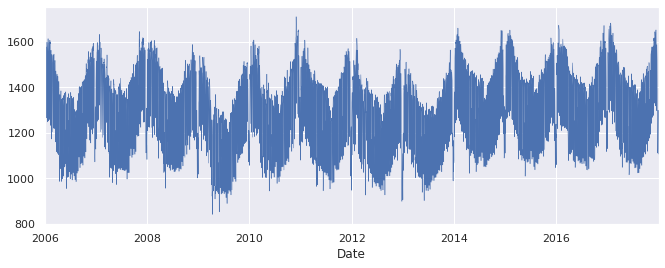

In [17]:
sns.set(rc={'figure.figsize':(11, 4)})
dtf['Consumption'].plot(linewidth=0.5);

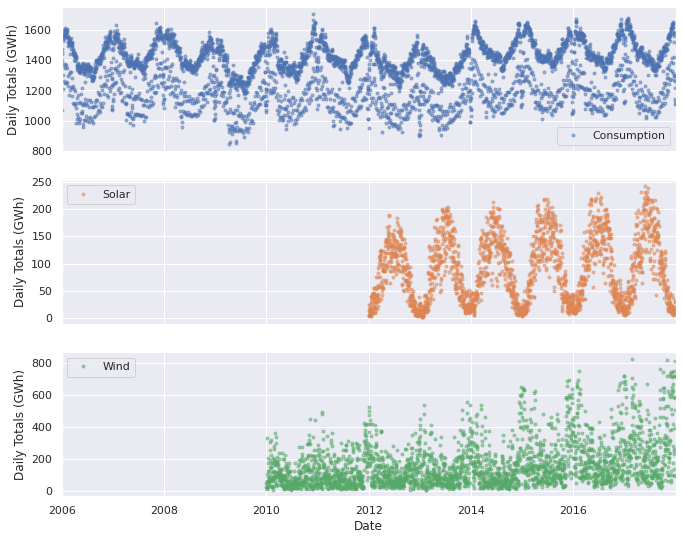

In [18]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = dtf[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

Deteccion de patrones emergentes:
-Electricity consumption is highest in winter, 



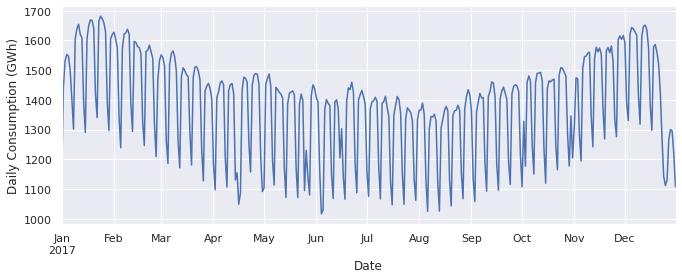

In [20]:
ax = dtf.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');


Aca inicia:
- https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205

- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/time_series/example_forecast.ipynb

In [15]:
## create time series
ts = dtf.groupby("Date")["Consumption"].sum().rename("consumo_m")
ts.head()


Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: consumo_m, dtype: float64

In [21]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 4383 | mean: 1339  | std: 166
moving --> len: 30  | mean: 1375  | std: 189


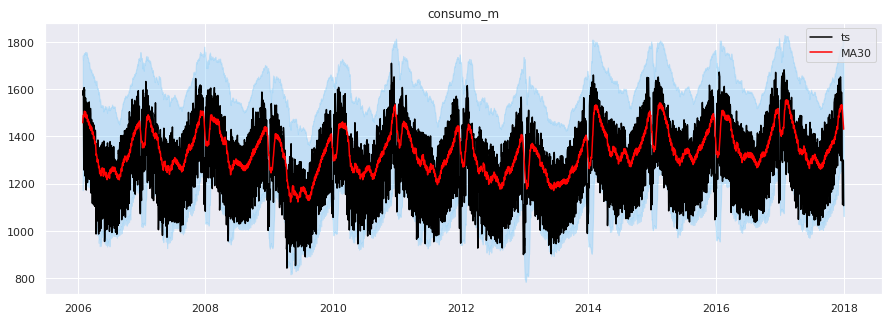

In [23]:
###############################################################################
#                         TS ANALYSIS                                         #
###############################################################################
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter
    :param ts: pandas Series
    :param window: num for rolling stats
    :param plot_intervals: bool - if True plots the conf interval
    :param plot_ma: bool - if True plots the moving avg
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='ts', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window), color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

In [24]:
def utils_generate_rw(y0, n, sigma, ymin=None, ymax=None):
    rw = [y0]
    for t in range(1, n):
        yt = rw[t-1] + np.random.normal(0,sigma)
        if (ymax is not None) and (yt > ymax):
            yt = rw[t-1] - abs(np.random.normal(0,sigma))
        elif (ymin is not None) and (yt < ymin):
            yt = rw[t-1] + abs(np.random.normal(0,sigma))
        rw.append(yt)
    return rw

'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param end: string - date to forecast (ex. end="2016-12-31")
    :param zoom: for plotting
:return
    dtf with columns "ts", "model", "residuals", "lower", "forecast", "upper" (No error)
'''
def forecast_rw(ts, pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## fit
    diff_ts = ts - ts.shift(1)
    sigma = diff_ts.std()
    rw = utils_generate_rw(y0=ts[0], n=len(ts), sigma=sigma, ymin=ts.min(), ymax=ts.max())
    dtf = ts.to_frame(name="ts").merge(pd.DataFrame(rw, index=ts.index, columns=["model"]), 
                                       how='left', left_index=True, right_index=True)
    
    ## index
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    preds = utils_generate_rw(y0=ts[-1], n=len(index), sigma=sigma, ymin=ts.min(), ymax=ts.max())
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## add intervals and plot
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf
    
